### ROC-AUC Model Comparison

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

2025-07-13 16:18:33.346625: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 16:18:33.580577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752419913.726657   15263 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752419913.751500   15263 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752419913.915984   15263 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
root = "./"
# Loading the datasets
data_dir = f"{root}/merged_dataset/"
batch_size = 32
img_height = 224
img_width  = 224
validation_split = 0.2
seed = 123

# ----- Loading data from the directory into training and validation sets ----- #
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names
print("\nClass names:", class_names)

Found 7675 files belonging to 3 classes.
Using 6140 files for training.


2025-07-13 16:18:53.034601: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 7675 files belonging to 3 classes.
Using 1535 files for validation.

Class names: ['type1', 'type2', 'type3']


2025-07-13 16:27:19.824215: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


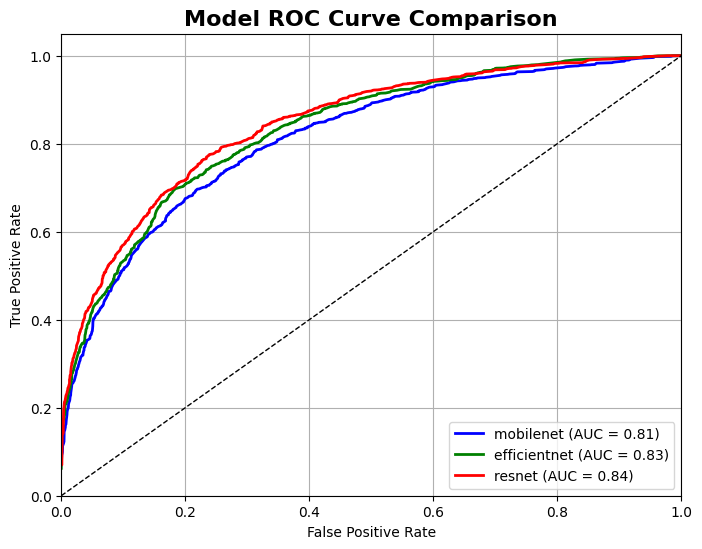

In [6]:
model_names = ["mobilenet", "efficientnet", "resnet"]
model_paths = [f"{root}/models/{name}_classifier.keras" for name in model_names]
colors = ['blue', 'green', 'red']
class_names = train_ds.class_names
n_classes = len(class_names)

plt.figure(figsize=(8, 6))

for model_path, name, color in zip(model_paths, model_names, colors):
    model = tf.keras.models.load_model(model_path)

    # Get predictions
    y_true = []
    y_pred_probs = []

    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_pred_probs.append(preds)
        y_true.append(labels.numpy())

    y_true = np.concatenate(y_true)
    y_pred_probs = np.concatenate(y_pred_probs)

    # ROC AUC (macro)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, color=color, label=f"{name} (AUC = {macro_auc:.2f})", lw=2)

# Reference diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model ROC Curve Comparison", fontsize=16, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(f"{root}/plots/all-models-roc-curve")
plt.show()